In [1]:
library(dplyr)
library(magrittr)
library(groupdata2)
library(mRMRe)
library(randomForest)
library(pROC)
library(verification)
library(cutpointr)
library(e1071)
library(corrplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: survival

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: fields

Loading required package: spam

Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or

In [2]:
Final_db = read.csv('/nfs/rnas/mligero/Github/TALENT_project/data/Talent_Radiomics_finaldb.csv', stringsAsFactors = TRUE)
Final_db$Patient = ifelse(Final_db$Patient<1000, as.character(paste(0, Final_db$Patient, sep = '')), as.character(Final_db$Patient)) # Convert Pat_ID to character (not numerical)
#report liver tumor burden
paste('Liver Burden:',median(Final_db$total_vol), '[',min(Final_db$total_vol), '-',max(Final_db$total_vol),']')

num_var= names(Final_db)[grep('original', colnames(Final_db))]
num_var= c(num_var,'total_vol')
#scale data and save mean and sd info
sel_vars= c(num_var,'Clinical_benefit')
s = scale(Final_db[num_var])
scale_info = attributes(s)
Final_db[num_var] = s

[1] "Liver Burden: 37409 [ 1365 - 2208555 ]"

In [3]:
# SPLIT TRAIN TEST
set.seed(6)
Final_db$Patient = as.factor(Final_db$Patient)
#split data 70%-30% maintining the same proportion of outcome (Clinical benefit)
split_data = partition(Final_db, p = 0.7, cat_col = 'Clinical_benefit')
train = data.frame(split_data[[1]])
test =  data.frame(split_data[[2]])

In [4]:
library(glmnet)
set.seed(6)

mdlY1 <-as.factor(as.matrix(train["Clinical_benefit"]))
mdlX1 <- as.matrix(data.frame(train[num_var]))

# implement cross validation to get the lamda of the most parsimonious model
cv <- cv.glmnet(mdlX1, mdlY1, family = "binomial", nfold = 3 , type.measure = "auc", parallel = TRUE, alpha = 1)

# train the LASSO model for the selected lambda
md1 <- glmnet(mdlX1,mdlY1, family = "binomial", lambda =cv$lambda.1se ,alpha = 1 )

#Get the selected features with non-zero coefficients
myCoefs1 <- coef(md1)
vars_nonzero1 = myCoefs1@Dimnames[[1]][ which(myCoefs1 != 0 ) ][-1] #intercept included


Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:spam’:

    det


Loaded glmnet 4.1-4

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


In [5]:
#because LASSO select too many features we implement mRMR
#mRMR
train$Clinical_benefit = as.ordered(train$Clinical_benefit)
sel_vars= c(vars_nonzero1,'Clinical_benefit')
feature_data <- mRMR.data(data = train[c(sel_vars)])
filter <- mRMR.classic(data = feature_data, target_indices = c(length(sel_vars)),
                       feature_count = 6) #num of features defined until the model multicolinearity was VIF~1

mrmr_data = colnames(train[c(sel_vars)][filter@filters[[1]][,1]])

train$Clinical_benefit=factor(train$Clinical_benefit, ordered = F)
model_rad <- glm(Clinical_benefit ~ .,family=binomial(link='logit'),data=train[c(mrmr_data,'Clinical_benefit')])
library(car)
vif(model_rad)



Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit


The following object is masked from ‘package:dplyr’:

    recode




original_shape_Flatness 
                                  1.558618 
                        original_glcm_Imc1 
                                  1.391453 
          original_firstorder_90Percentile 
                                  1.152298 
original_glrlm_LongRunLowGrayLevelEmphasis 
                                  1.173895 
              original_firstorder_Skewness 
                                  1.313038 
                 original_shape_Sphericity 
                                  1.463935

In [6]:
#visualize results
R_1= pROC::roc(response = train$Clinical_benefit, predictor = predict(model_rad,train,type = 'response'),direction='<', ci=TRUE)
R_1
#plot(R_1, print.auc = T)

R_2= pROC::roc(response = test$Clinical_benefit, predictor = predict(model_rad,test,type = 'response'),direction='<', ci=TRUE)
R_2
#plot(R_2, add=TRUE, print.auc = T)

Setting levels: control = no, case = yes




Call:
roc.default(response = train$Clinical_benefit, predictor = predict(model_rad,     train, type = "response"), direction = "<", ci = TRUE)

Data: predict(model_rad, train, type = "response") in 24 controls (train$Clinical_benefit no) < 21 cases (train$Clinical_benefit yes).
Area under the curve: 0.75
95% CI: 0.6006-0.8994 (DeLong)

Setting levels: control = no, case = yes




Call:
roc.default(response = test$Clinical_benefit, predictor = predict(model_rad,     test, type = "response"), direction = "<", ci = TRUE)

Data: predict(model_rad, test, type = "response") in 11 controls (test$Clinical_benefit no) < 9 cases (test$Clinical_benefit yes).
Area under the curve: 0.6667
95% CI: 0.4149-0.9185 (DeLong)

In [7]:
coefs_sd = summary(model_rad)
CI95_high = coefs_sd$coefficients[,1]+1.96*coefs_sd$coefficients[,2]
CI95_low = coefs_sd$coefficients[,1]-1.96*coefs_sd$coefficients[,2]
coef = coefs_sd$coefficients[,1]
coefs_md = data.frame(names = as.character(names(coef)[-1]),vars = paste(round(coef,2), '[',round(CI95_low,2),'-',round(CI95_high,2),']', sep = '')[-1])
coefs_md$names = as.character(coefs_md$names)
coefs_md

names,vars
<chr>,<chr>
original_shape_Flatness,-0.82[-1.6--0.05]
original_glcm_Imc1,0.31[-0.47-1.09]
original_firstorder_90Percentile,0.37[-0.29-1.04]
original_glrlm_LongRunLowGrayLevelEmphasis,0.16[-0.58-0.91]
original_firstorder_Skewness,0.34[-0.35-1.03]
original_shape_Sphericity,0.84[0.05-1.63]


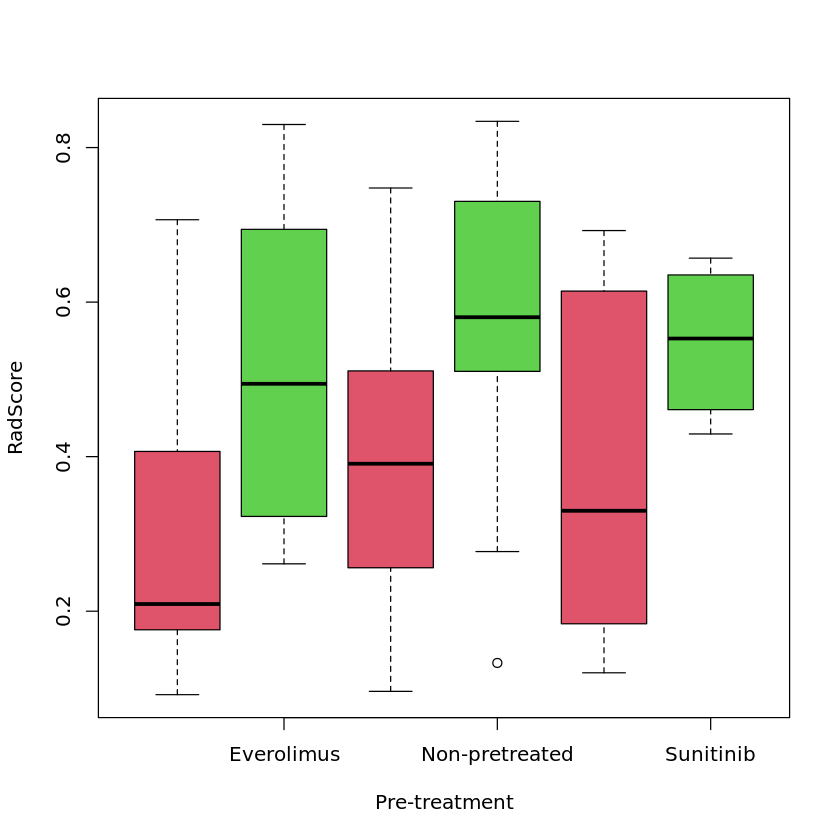

In [8]:
#check differences between pretreated pts 
Final_db$RadScore = predict(model_rad, Final_db, type='response')
Final_db$Clinical_benefit = factor(Final_db$Clinical_benefit )
Final_db$Pretreatment = ifelse(Final_db$PriorTarget_Type_P !='Non-pretreated', 'Pretreated', 'Non-pretreated')
boxplot(Final_db$RadScore~Final_db$Clinical_benefit+Final_db$PriorTarget_Type_P, col=rep(unique(as.numeric(Final_db$Clinical_benefit)+1),3),  xlab = 'Pre-treatment', ylab='RadScore',xaxt = 'n')
axis(1,at=seq(2,6,2),labels=c('Everolimus', 'Non-pretreated','Sunitinib'),cex.axis=1)

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




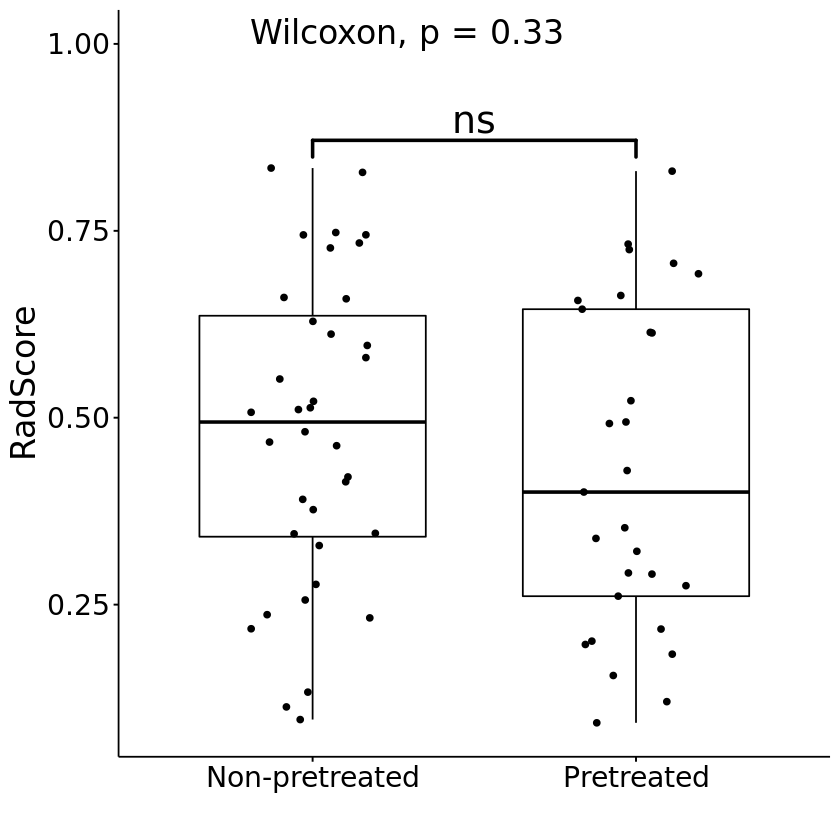

In [9]:
#Check if there are significant differences in pretreated patients
library(ggpubr)
my_comparisons <- list(c("Non-pretreated", "Pretreated"))
p <- ggboxplot(Final_db, x = "Pretreatment", y = "RadScore",
               palette = "jco", xlab = '',
               add = "jitter")
#  Add p-value
#p + stat_compare_means(comparisons = my_comparisons)
# Change method
p + stat_compare_means(method = "wilcox.test", label.y = 1, size = 7)+
  stat_compare_means(method = "wilcox.test",label = "p.signif",comparisons = my_comparisons, bracket.size = 1, hide.ns = F,size = 8)+
  theme(axis.text=element_text(size=17),axis.title=element_text(size=20), strip.text=element_text(size=0))

In [10]:
# VALIDATION ####
#read data
Finalval_db = read.csv('/nfs/rnas/mligero/Github/TALENT_project/data/Talent_Radiomics_validationdb.csv', stringsAsFactors = F)

paste('Liver Burden:',median(Finalval_db$total_vol), '[',min(Finalval_db$total_vol), '-',max(Finalval_db$total_vol),']')

Finalval_db[num_var] = scale(Finalval_db[num_var])

[1] "Liver Burden: 108649 [ 732 - 1054173 ]"

In [11]:
Finalval_db$Clinical_benefit= factor(Finalval_db$Clinical_benefit)

In [12]:
#LOGISTIC REGRESSION
R_3= pROC::roc(response = as.numeric(Finalval_db$Clinical_benefit), predictor = as.numeric(predict(model_rad,Finalval_db, type = "response")), direction ='<', ci=TRUE)
R_3

Setting levels: control = 1, case = 2




Call:
roc.default(response = as.numeric(Finalval_db$Clinical_benefit),     predictor = as.numeric(predict(model_rad, Finalval_db, type = "response")),     direction = "<", ci = TRUE)

Data: as.numeric(predict(model_rad, Finalval_db, type = "response")) in 12 controls (as.numeric(Finalval_db$Clinical_benefit) 1) < 12 cases (as.numeric(Finalval_db$Clinical_benefit) 2).
Area under the curve: 0.6667
95% CI: 0.4271-0.9062 (DeLong)

In [13]:
#find cutoff for the training model and get SE, SP and others for that cutoff
df_cutoff = data.frame(outcome = train$Clinical_benefit, predicted = predict(model_rad,train,type = 'response'))

p <- cutpointr(df_cutoff, x = predicted, class =outcome, 
              method = maximize_metric, metric = youden)
p$optimal_cutpoint

R_1$auc;R_1$ci;coords(R_1,input = 'threshold', x = p$optimal_cutpoint,
                      ret=c( "accuracy","sensitivity","specificity", "npv" , "ppv","tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_1$response)-1, 
                                                  R_1$predictor)$p.value
R_2$auc;R_2$ci;coords(R_2,input = 'threshold', x =  p$optimal_cutpoint,
                      ret=c("threshold","accuracy", "specificity", "sensitivity", "npv" , "ppv","tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_2$response)-1, 
                                                  R_2$predictor)$p.value
R_3$auc;R_3$ci;coords(R_3,input = 'threshold', x =  p$optimal_cutpoint,
                      ret=c("threshold","accuracy", "specificity", "sensitivity", "npv" , "ppv","tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_3$response)-1, 
                                                  R_3$predictor)$p.value


Assuming the positive class is yes

Assuming the positive class has higher x values



[1] 0.4922875

Area under the curve: 0.75

95% CI: 0.6006-0.8994 (DeLong)

,accuracy,sensitivity,specificity,npv,ppv,tp,tn,fp,fn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
threshold,0.7777778,0.7619048,0.7916667,0.7916667,0.7619048,16,19,5,5


[1] 0.001801438

Area under the curve: 0.6667

95% CI: 0.4149-0.9185 (DeLong)

,threshold,accuracy,specificity,sensitivity,npv,ppv,tp,tn,fp,fn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
threshold,0.4922875,0.55,0.5454545,0.5555556,0.6,0.5,5,6,5,4


[1] 0.1149321

Area under the curve: 0.6667

95% CI: 0.4271-0.9062 (DeLong)

,threshold,accuracy,specificity,sensitivity,npv,ppv,tp,tn,fp,fn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
threshold,0.4922875,0.625,0.6666667,0.5833333,0.6153846,0.6363636,7,8,4,5


[1] 0.08909101

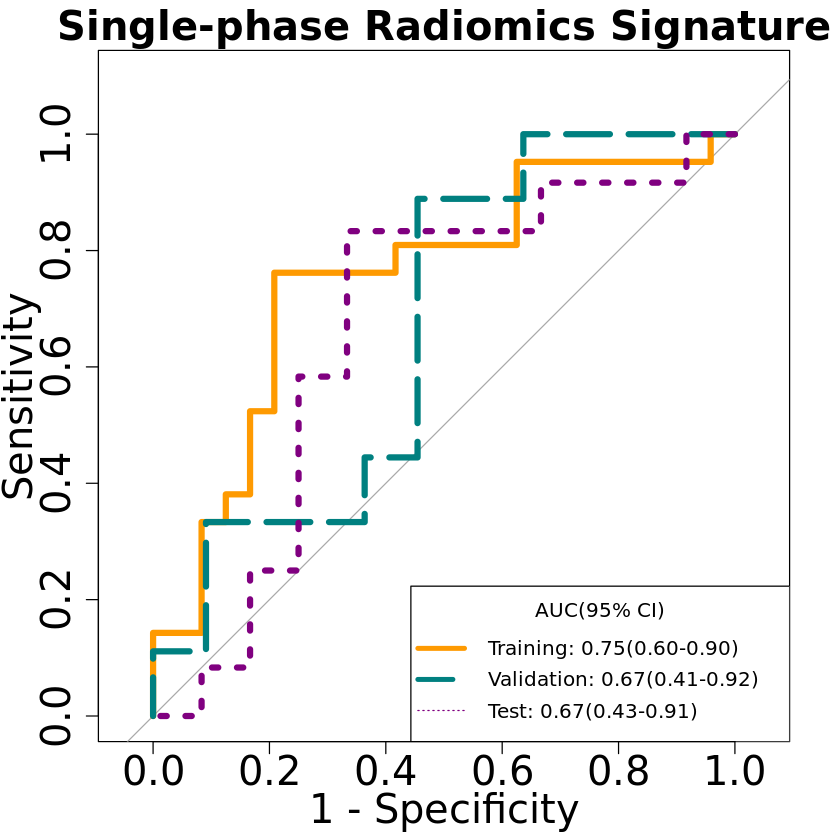

In [14]:
# PLOT ROC ####~

col_1 = rgb(red =254,green = 154,blue = 1,maxColorValue = 255)
col_2 = rgb(red =0,green = 128,blue = 128,maxColorValue = 255)
col_3 = rgb(red =128,green = 0,blue = 128,maxColorValue = 255)


#ROC curve generate figure
#svg(filename="PartA_ROCRAD.svg", width=5, height=5, pointsize=6)
par(pty = 's')
par(mar=c(5,2.5,6.1,3.5),xpd = F,mgp = c(1, 1,0))
plot(R_1, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_1$ci),
     col = col_1,type='l', xlab = "", ylab = "",
     print.auc = FALSE, print.thres=FALSE, lwd=5,
     main= 'Single-phase Radiomics Signature',cex.main = 2,
     print.thres.pch=19,print.thres.adj=c(-1.05,0.3),
     print.thres.cex=1.3,print.thres.col="black",
     add=FALSE,cex.lab = 1.8, cex.axis = 2, ylim = c(0,1.1))

legend('bottomright', legend = c(paste('Training: ',format(round(R_1$auc,2),nsmall = 2),'(',format(round(R_1$ci[1],2),nsmall = 2),'-',format(round(R_1$ci[3],2),nsmall = 2),')',sep=''),
                                 paste('Validation: ',format(round(R_2$auc,2),nsmall = 2),'(',format(round(R_2$ci[1],2),nsmall = 2),'-',format(round(R_2$ci[3],2),nsmall = 2),')',sep = ''),
                                 paste('Test: ',format(round(R_3$auc,2),nsmall = 2),'(',format(round(R_3$ci[1],2),nsmall = 2),'-',format(round(R_3$ci[3],2),nsmall = 2),')',sep = '')),             
       lty = c(1,5,3),lwd = c(4,4,1),col=c(col_1,col_2,col_3), xjust = 4, yjust = 1,
       title = "AUC(95% CI)", pch = c(NA,NA,NA), cex = 1)

plot(R_2, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_2$ci),
     col = col_2, type = 'l',lty=5,lwd=5,
     print.auc = FALSE, print.thres=FALSE, print.thres.col="black",
     print.thres.pch=19,print.thres.adj=c(1,-0.7),print.thres.cex=1.3,add=TRUE,ylim = c(0,1.1))


plot(R_3, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_3$ci),
     col = col_3, type = 'l',lty=3,lwd=5,
     print.auc = FALSE, print.thres=FALSE, print.thres.col="black",
     print.thres.pch=19,print.thres.adj=c(1,-0.7),print.thres.cex=1.3,add=TRUE,ylim = c(0,1.1))


axis(side = 1,seq(1.0,0.0,-0.2),pos = -0.044,c('0.0','0.2','0.4','0.6','0.8','1.0'),cex.axis = 2)
mtext(text = "1 - Specificity",side = 1,line = 3.5, cex = 2)

mtext(text = "Sensitivity",
      side = 2, line = 3.5, cex = 2)
#dev.off()

In [15]:
Finalval_db$RadScore = predict(model_rad, Finalval_db, type='response')
total_db = rbind(Final_db[c('Patient', 'original_firstorder_90Percentile', 'Grado','Ki67', 'RadScore')] , Finalval_db[c('Patient', 'original_firstorder_90Percentile', 'Grado','Ki67','RadScore')])
total_db$grade = ifelse(total_db$Grado>=2, 'Grade II-III', 'Grade <II' )
total_db$RadScore_d = factor(ifelse(total_db$RadScore>p$optimal_cutpoint, 'HighRADscore', 'LowRADscore'))

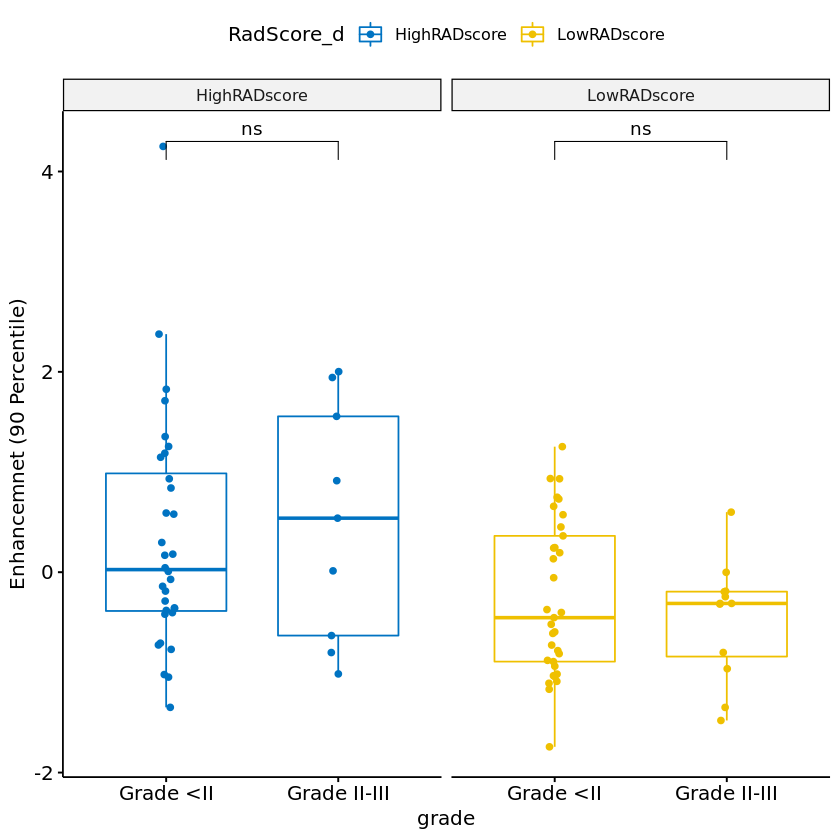

In [16]:
#checking for significant differences between grade 
library(ggpubr)

p <- ggboxplot(subset(total_db, !is.na(grade)), x = "grade", y = "original_firstorder_90Percentile",
          color = "RadScore_d", palette = "jco",
          add = "jitter")
# Change method
p + stat_compare_means(comparisons = list(c('Grade <II','Grade II-III')),label = "p.signif", label.y = 4, label.x = 1.5) + 
facet_wrap(~RadScore_d)+ylab('Enhancemnet (90 Percentile)')

In [ ]:
train$RADscore = predict(model_rad,train,type = 'response')
test$RADscore = predict(model_rad,test,type = 'response')
Finalval_db$RADscore = predict(model_rad,Finalval_db,type = 'response')
model_clinrad <- glm(Clinical_benefit ~.,family=binomial(link='logit'), 
                     data=train[c('Clinical_benefit','RADscore','Ki67','Cohort')])
summary(model_clinrad)
anova(model_clinrad,test="Chisq")
coefs_sd = summary(model_clinrad)
CI95_high = coefs_sd$coefficients[,1]+1.96*coefs_sd$coefficients[,2]
CI95_low = coefs_sd$coefficients[,1]-1.96*coefs_sd$coefficients[,2]
coef = coefs_sd$coefficients[,1]
coefs_md = data.frame(names = as.character(names(coef)[-1]),vars = paste(round(coef,2), '[',round(CI95_low,2),'-',round(CI95_high,2),']', sep = '')[-1])
coefs_md$names = as.character(coefs_md$names)

In [ ]:
par(pty = 's')
par(mar=c(5,2.5,6.1,3.5),xpd = F,mgp = c(1, 1,0))
R_3= pROC::roc(response = train$Clinical_benefit, predictor = predict(model_clinrad,train,type = 'response'), ci=TRUE)
R_3

R_4= pROC::roc(response = test$Clinical_benefit, predictor = predict(model_clinrad,test,type = 'response'), ci=TRUE)
R_4

R_5= pROC::roc(response = Finalval_db$Clinical_benefit, predictor = predict(model_clinrad,Finalval_db,type = 'response'), ci=TRUE)
R_5


In [ ]:
#find cutoff of the combined clinical and radiomics model
df_cutoff = data.frame(outcome = model_clinrad$y, predicted = model_clinrad$fitted.values)

p <- cutpointr(df_cutoff, x = predicted, class =outcome, 
              method = maximize_metric, metric = youden)
p$optimal_cutpoint

R_3$auc;R_3$ci;coords(R_3,input = 'threshold', x = p$optimal_cutpoint,
                      ret=c( "accuracy","sensitivity","specificity", "npv" , "ppv","tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_3$response)-1,R_3$predictor)$p.value

R_4$auc;R_4$ci;coords(R_4,input = 'threshold', x =p$optimal_cutpoint,
                      ret=c("threshold", "accuracy","specificity", "sensitivity", "tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_4$response)-1, 
                                                  R_4$predictor)$p.value

R_5$auc;R_5$ci;coords(R_5,input = 'threshold', x = p$optimal_cutpoint,
                      ret=c("threshold","accuracy", "specificity", "sensitivity", "tp", "tn","fp", "fn"),
                      transpose = FALSE);roc.area(as.numeric(R_5$response)-1, 
                                                  R_5$predictor)$p.value


par(pty = 's')
col_1 = rgb(red =254,green = 154,blue = 1,maxColorValue = 255)
col_2 = rgb(red =0,green = 128,blue = 128,maxColorValue = 255)
col_3 = rgb(red =128,green = 0,blue = 128,maxColorValue = 255)

In [ ]:
#ROC cruve generate figure for clinical radiomics signature
#svg(filename="PartA_ROCCLINRAD.svg", width=5, height=5, pointsize=6)
par(pty = 's')
par(mar=c(5,2.5,6.1,3.5),xpd = F,mgp = c(1, 1,0))
plot(R_3, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_3$ci),
     col = col_1,type='l', xlab = "", ylab = "",
     print.auc = FALSE, print.thres=FALSE, lwd=5,
     main= 'Radiomics-Clinical Signature',cex.main = 2,
     print.thres.pch=19,print.thres.adj=c(-1.05,0.3),
     print.thres.cex=1.3,print.thres.col="black",
     add=FALSE,cex.lab = 1.8, cex.axis = 2, ylim = c(0,1.1))


legend('bottomright', legend = c(paste('Training: ',format(round(R_3$auc,2),nsmall = 2),'(',format(round(R_3$ci[1],2),nsmall = 2),'-',format(round(R_3$ci[3],2),nsmall = 2),')',sep=''),
                                 paste('Validation: ',format(round(R_4$auc,2),nsmall = 2),'(',format(round(R_4$ci[1],2),nsmall = 2),'-',format(round(R_4$ci[3],2),nsmall = 2),')',sep = ''),
                                 paste('Test: ',format(round(R_5$auc,2),nsmall = 2),'(',format(round(R_5$ci[1],2),nsmall = 2),'-',format(round(R_5$ci[3],2),nsmall = 2),')',sep = '')),             
       lty = c(1,5,4),lwd = c(4,4,4),col=c(col_1,col_2,col_3), xjust = 3, yjust = 1,
       title = "AUC(95% CI)", pch = c(NA,NA,NA), cex =1)

plot(R_4, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_4$ci),
     col = col_2, type = 'l',lty=5,lwd=5,
     print.auc = FALSE, print.thres=FALSE, print.thres.col="black",
     print.thres.pch=19,print.thres.adj=c(1,-0.7),print.thres.cex=1.3,add=TRUE,ylim = c(0,1.1))

plot(R_5, xaxt = 'n', legacy.axes = TRUE, ci=!is.null(R_5$ci),
     col = col_3, type = 'l',lty=4,lwd=5,
     print.auc = FALSE, print.thres=FALSE, print.thres.col="black",
     print.thres.pch=19,print.thres.adj=c(1,-0.7),print.thres.cex=1.3,add=TRUE,ylim = c(0,1.1))


axis(side = 1,seq(1.0,0.0,-0.2),pos = -0.044,c('0.0','0.2','0.4','0.6','0.8','1.0'),cex.axis = 2)
mtext(text = "1 - Specificity",side = 1,line = 3.5, cex = 2)

mtext(text = "Sensitivity",
      side = 2, line = 3.5, cex = 2)
#dev.off()

In [ ]:
#dis function gets the HR with confidence intervals, pvalue, AIC and C-index of the unimodal models
get_hr = function(mdc){
  HR = exp(coef(mdc))
  HRCIlow = exp(confint(mdc))[,1]
  HRCIhigh = exp(confint(mdc))[,2]
  p_val_model = summary(mdc)$coefficients[,5]
  aic= AIC(mdc)
  c_idx= mdc$concordance[6]
  c_idx_low= mdc$concordance[6] - 1.96*mdc$concordance[7]
  c_idx_upp= mdc$concordance[6] +1.96*mdc$concordance[7]
  temp = cox.zph(mdc)
  df = data.frame(paste(round(HR,2),'[', round(HRCIlow,2),'-',round(HRCIhigh,2),']', sep=''),
                  round(p_val_model,3), round(aic,2),
                  paste(round(c_idx,2),'[',round(c_idx_low,2),'-',round(c_idx_upp,2),']',sep =''),
                  p_val = temp$table[c(1:length(temp$table[,1])-1),3])
  colnames(df) = c('HR', 'pval', 'AIC', 'Cindex', 'pvaldependence')
  df
}

In [ ]:
#generate KM figure for radiomics score
library(survminer)
#svg(filename="PartB_KMRAD.svg", width=7, height=5, pointsize=6)
Final_db$RADscore = predict(model_rad, Final_db, type='response')
Final_db$RadScore_d = ifelse(Final_db$RADscore>0.49, 1,0) #0.49 is the optimal cutoff
fit3 = survfit(Surv(Time_PFS,Event_PFS) ~ RadScore_d, data = Final_db)
ggsurvplot(fit3, censor.shape="|", censor.size = 4, palette = c(col_1, col_3),
                         ggtheme = theme_bw(),
                         xlim = c(0,50), title = 'Kaplan-Meier for predicting PFS',
                         font.title = c(17,'plain', 'black'), 
                         font.caption = c(10,'plain', 'black'), 
                         font.x = c(17,'plain', 'black'),
                         font.y = c(20,'plain', 'black'),
                         font.tickslab  = c(13,'plain', 'black'), 
                         font.legend  = c(14,'plain', 'black'),
                         legend = 'top',
                         legend.size = 2,
                         legend.title = element_blank(),
                         legend.labs = c("Low RAD-Score","High RAD-Score"),
                         xlab = 'Time (months)', size = 1,  
                         ylab = 'PFS probability',
                         data = Final_db,
                         risk.table = F, pval = T)
#dev.off()

In [ ]:
#generate KM figure for combined clinicalradiomics score
library(survminer)
#svg(filename="PartB_KMCLINRAD.svg", width=7, height=5, pointsize=6)
Final_db$RADscore = predict(model_rad, Final_db, type='response')
Final_db$ClinRADscore = predict(model_clinrad, Final_db, type='response')
Final_db$RadScore_d = ifelse(Final_db$ClinRADscore>0.36, 1,0) #for the optimal cutoff
fit3 = survfit(Surv(Time_PFS,Event_PFS) ~ RadScore_d, data = Final_db)
ggsurvplot(fit3, censor.shape="|", censor.size = 4, palette = c(col_1, col_3),
                         ggtheme = theme_bw(),
                         xlim = c(0,50), title = 'Kaplan-Meier for predicting PFS',
                         font.title = c(17,'plain', 'black'), 
                         font.caption = c(10,'plain', 'black'), 
                         font.x = c(17,'plain', 'black'),
                         font.y = c(20,'plain', 'black'),
                         font.tickslab  = c(13,'plain', 'black'), 
                         font.legend  = c(14,'plain', 'black'),
                         legend = 'top',
                         legend.size = 2,
                         legend.title = element_blank(),
                         legend.labs = c("Low RADClincal-Score","High RADClincal-Score"),
                         xlab = 'Time (months)', size = 1,  
                         ylab = 'PFS probability',
                         data = Final_db,
                         risk.table = F, pval = T)
#dev.off()

In [ ]:
Final_db$Grado

In [ ]:
Final_db$Tumor_Burden = factor(Final_db$Tumor_Burden )
Final_db$Grado = factor(Final_db$Grado )

In [ ]:
form = as.formula(paste('Surv(Time_PFS, Event_PFS) ~ Tumor_Burden'))
coxmd = coxph(form, Final_db)
summary(coxmd)

In [ ]:
# 8. cox univariate ----
clin_params = c('RADscore','ClinRADscore','Ki67','Cohort', 'Grado')

HR_uni = list()
for (i in clin_params){
  form = as.formula(paste('Surv(Time_PFS, Event_PFS) ~ ' , i,'', sep = ''))
  coxmd = coxph(form, Final_db)
  summary(coxmd)
  HR_uni = rbind(HR_uni,get_hr(coxmd))
}
rownames(HR_uni) = clin_params
HR_uni

In [ ]:
Final_dbrad = Final_db

## CORRELATION WITH CLINICAL FACTORS

In [ ]:
blood_db = read.csv('/nfs/rnas/mligero/Github/TALENT_project/data/biomarcadores_TALENT.csv', stringsAsFactors = FALSE)
blood_db$Patient = ifelse(blood_db$Patient<1000, as.character(paste(0, blood_db$Patient, sep = '')), as.character(blood_db$Patient)) # Convert Pat_ID to character (not numerical)
table(blood_db$Patient %in% Final_dbrad$Patient)
Final_db=inner_join(Final_dbrad[c('Patient', 'acquisition', 'RadScore', 'Time_PFS',"original_firstorder_90Percentile",
                             "original_shape_Sphericity","Clinical_benefit")], 
                    blood_db, by='Patient')
Final_db$Patient = paste('p', Final_db$Patient, sep='')

In [ ]:
Final_db$VEGFR = factor(ifelse(Final_db$VEGF.R2.<median(Final_db$VEGF.R2.),"low","high"))
Final_db$ANG = factor(ifelse(Final_db$ANG.2<median(Final_db$ANG.2),"low","high"))
# Define different cohorts for pretreatment
suni_subset= subset(Final_db, PriorTarget_Type_P =='Sunitinib')
everolimus_subset = subset(Final_db, PriorTarget_Type_P =='Everolimus')
nopre_db = subset(Final_db, PriorTarget_Type_P =='Non-pretreated')
noSuni = subset(Final_db, PriorTarget_Type_P!='Sunitinib')
Final_db$Pre_treatment = ifelse(Final_db$PriorTarget_Type_P !='Non-pretreated', 'Pre-treated', 'Non-pretreated')

In [ ]:
boxplot(Final_db$VEGF.R2.~Final_db$Clinical_benefit+Final_db$Pre_treatment, col=as.numeric(as.factor(Final_db$Clinical_benefit))+1,  xlab = 'Pre-treatment', ylab='VEGFR1',xaxt = 'n')
axis(1,at=seq(1.5,3.5,2),labels=c('Non-pretreated','Pre-treated'),cex.axis=1)

In [ ]:
# Check associations between vascularization factors and response
library(ggpubr)
p <- ggboxplot(nopre_db, x = "Clinical_benefit", y = "VEGF.R2.",
          color = "Clinical_benefit", palette = "jco",
          add = "jitter")
# Change method
p + stat_compare_means(comparisons = list(c('yes','no')),label = "p.value", label.y = 28000, label.x = 1.5)+ylab('VEGFR')
p <- ggboxplot(Final_db, x = "Clinical_benefit", y = "VEGF.R2.",
          color = "Clinical_benefit", palette = "jco",
          add = "jitter")
# Change method
p + stat_compare_means(comparisons = list(c('yes','no','yes','no')),label = "p.value", label.y = 28000, label.x = 1.5) + facet_wrap(~Pre_treatment)+ylab('VEGFR')

#------------------------------
ggplot(data = Final_db,
   mapping = aes(x = Clinical_benefit,
                 y = VEGF.R2.)) +
  geom_boxplot(aes(fill = Clinical_benefit))+
  stat_compare_means(comparisons = list(c('yes','no')),
                     label = 'p.value',
                     label.x = 1.25,
                     label.y = 28000) + facet_wrap(~Pre_treatment)

In [ ]:
library(ggpubr)
my_comparisons <- list(c("low", "high"))
p <- ggboxplot(Final_db, x = "VEGFR", y = "RadScore",
               palette = "jco",
               add = "jitter")
#  Add p-value
#p + stat_compare_means(comparisons = my_comparisons)
# Change method
p + stat_compare_means(method = "wilcox.test", label.y = 1,size = 7)+
  stat_compare_means(method = "wilcox.test",label = "p.signif",comparisons = my_comparisons, bracket.size = 1, hide.ns = T,size = 8)+
  theme(axis.text=element_text(size=17),axis.title=element_text(size=20), strip.text=element_text(size=0))

In [ ]:
library(ComplexHeatmap)
data = as.matrix(Final_db[c('ANG.2','VEGF.R2.')])
mat = as.matrix(scale(data)) #numerical features from database
Heatmap(mat, name = "SignExp",clustering_method_columns="complete",  cluster_columns = FALSE, row_km=2)

In [ ]:
hc = hclust(dist(mat), method = "complete", members = NULL)
Final_db$hc <- cutree(hc, k =2)
#Final_db$hc[Final_db$hc==2]=1

#wilcox.test(Final_db$RadScore~Final_db$hc)
library(ggpubr)

my_comparisons <- list(c("ClusterA", "ClusterB"))
p <- ggboxplot(Final_db, x = "hc", y = "RadScore",
               palette = "jco",
               add = "jitter")
#  Add p-value
p + stat_compare_means(comparisons = my_comparisons)
# Change method
p + stat_compare_means(method = "wilcox.test", label.y = 1,size = 7)+
  stat_compare_means(method = "wilcox.test",label = "p.signif",comparisons = my_comparisons, bracket.size = 1, hide.ns = T,size = 8)+
  theme(axis.text=element_text(size=17),axis.title=element_text(size=20), strip.text=element_text(size=0))

In [ ]:

Final_db%>%group_by(hc)%>%
  dplyr::summarize(n = n(),
            median = median(VEGF.R2.),
            min = quantile(VEGF.R2.,c(0.25)),
            max = quantile(VEGF.R2.,c(0.75)))


Final_db%>%group_by(hc)%>%
  dplyr::summarize(n = n(),
            median = median(ANG.2),
            min = quantile(ANG.2,c(0.25)),
            max = quantile(ANG.2,c(0.75)))
           
Final_db%>%group_by(hc)%>%
  dplyr::summarize(n = n(),
            median = median(RadScore),
            min = quantile(RadScore,c(0.25)),
            max = quantile(RadScore,c(0.75)))

In [ ]:
library(ComplexHeatmap)
library(circlize)
names(Final_db)[c(9,14)] = c('ANG-2', 'VEGF-R2')
data = as.matrix(Final_db[c('ANG-2', 'VEGF-R2')])
mat = as.matrix(scale(data))
hc = hclust(dist(mat), method = "complete", members = NULL)
subgroup <- cutree(hc, k =2)
rad = as.matrix(Final_db$RadScore)
subgroup <- ifelse(subgroup ==1, 'ClusterA', 'ClusterB')
RAD_col = colorRamp2(c(0, 0.75), c("red","green")) 
col = list(Cluster = c("ClusterA" = "green", "ClusterB" = "red"),RAD = RAD_col)
ha = rowAnnotation(Cluster = subgroup, RAD = rad, col=col)
col_rnorm = colorRamp2(c(-3, 0, 3), c("red", "white", "blue"))


panel_fun = function(index, nm) {
    pushViewport(viewport(xscale = c(0,1), yscale = c(0, 2))) 
    grid.xaxis(gp = gpar(fontsize = 8), main =TRUE)
    if (nm == 'ClusterA'){
        grid.boxplot(rad[index, drop = FALSE], pos = 1, direction = "horizontal", gp = gpar(fill = "green", xaxt = 'n'))}
    if (nm == 'ClusterB'){
        grid.boxplot(rad[index, ], pos = 1, direction = "horizontal", gp = gpar(fill = "red", yaxis = 'RADscore'))
    }
    popViewport()
}

anno = anno_link(align_to = subgroup, which = "row", panel_fun = panel_fun, 
    size = unit(2, "cm"), gap = unit(-5, "cm"), width = unit(7, "cm"))
#svg(filename="Heatmap.svg", width=, height=5, pointsize=12)    
Heatmap(mat, name = " ", cluster_columns = FALSE, left_annotation  = ha, right_annotation = rowAnnotation(RAD = anno), row_split = subgroup)